In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import Transformer
import torch.nn.utils.rnn as rnn_utils
import torch.nn.functional as F

import scipy

from datetime import datetime

In [2]:
def seed_everything(seed=7):

    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed=7)

In [3]:
CUDA_DEV = 0
NUM_TAGS = 256

In [4]:
df_train = pd.read_csv('train_yandexcup.csv')
df_test = pd.read_csv('test_yandexcup.csv')

In [ ]:
df_train.sample(5)

,track,tags
13617,59931,"1,18,224"
47660,14842,"1,18,219,250"
17910,73128,"0,5,10,73"
40197,75183,"23,173,234"
13827,20296,"6,9,39,81,117"


In [ ]:
df_train.shape

(51134, 2)

In [ ]:
df_test.shape

(25580, 1)

In [5]:
import tarfile
import os

# Путь к архиву
archive_path = '/content/drive/MyDrive/track_embeddings.tar.gz'

# Распаковываем архив
with tarfile.open(archive_path, 'r:gz') as tar:
    tar.extractall('/content/track_embeddings')

# Теперь обрабатываем файлы
track_idx2embeds = {}
for fn in tqdm(glob('/content/track_embeddings/*')):
    track_idx = int(os.path.basename(fn).split('.')[0])
    embeds = np.load(fn)
    embeds = torch.from_numpy(embeds).to('cuda')
    track_idx2embeds[track_idx] = embeds

100%|██████████| 76714/76714 [04:07<00:00, 310.04it/s]


In [ ]:
track_idx2embeds

{76530: tensor([[1.1919, 1.3928, 1.8729,  ..., 1.7788, 2.1644, 1.2061],
         [1.0552, 1.2913, 1.7753,  ..., 1.5937, 1.9904, 1.3822],
         [1.1353, 1.2617, 1.7232,  ..., 1.4856, 2.0237, 1.2737],
         ...,
         [0.3896, 0.5978, 0.7612,  ..., 0.6929, 0.4916, 0.4831],
         [0.6990, 0.8430, 0.7902,  ..., 0.8609, 1.0799, 0.9348],
         [0.9266, 1.2217, 1.5852,  ..., 1.3382, 1.7755, 1.0931]],
        device='cuda:0'),
 26642: tensor([[1.3062, 1.3609, 1.9987,  ..., 2.0124, 2.0981, 2.0285],
         [0.7735, 0.6413, 1.2260,  ..., 1.1303, 1.2344, 1.0394],
         [0.8027, 0.6753, 1.0905,  ..., 1.0456, 1.1733, 1.0441],
         ...,
         [0.7199, 1.1199, 1.4780,  ..., 1.3825, 1.5786, 1.2413],
         [1.2420, 1.5807, 2.0031,  ..., 2.0373, 2.2271, 1.9289],
         [1.4092, 1.6671, 2.1900,  ..., 2.2958, 2.4116, 2.3418]],
        device='cuda:0'),
 26578: tensor([[0.5035, 0.5421, 0.6957,  ..., 1.1873, 1.0568, 0.7179],
         [0.2680, 0.5658, 0.9069,  ..., 0.7873, 0.69

## feature engineering

In [6]:
def make_more_emb(data):
  # 404 - макс длина песни
  # data = track_idx2embeds[track_idx]
  data = data.to("cpu:0")
  data = data.mean(dim=1)
  kol = torch.tensor(data.shape[0], dtype=torch.int64).unsqueeze(0)
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
  std = torch.tensor(data.std(), dtype=data.dtype).unsqueeze(0)
  new_array = torch.zeros(404, dtype=data.dtype)
  new_array[:kol[0]] = data
  diff = torch.diff(new_array)
  new_array = torch.zeros(768-408, dtype=data.dtype)
  return torch.cat((kol, min_, max_, var, std, diff, new_array))

In [7]:
for key, val in tqdm(track_idx2embeds.items()):
  emb = torch.cat((val.to("cpu:0"), make_more_emb(embeds.clone()).unsqueeze(0)), dim=0)
  # track_idx2embeds[key] = None
  track_idx2embeds[key] = emb.to('cuda')

  0%|          | 0/76714 [00:00<?, ?it/s]<ipython-input-6-e94435afa4aa>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
<ipython-input-6-e94435afa4aa>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
<ipython-input-6-e94435afa4aa>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
<ipython-input-6-e94435afa4aa>:10: UserWarning: To copy construct from a te

In [8]:
def make_more_emb2(data):
  # 404 - макс длина песни
  # data = track_idx2embeds[track_idx]
  data = data.to("cpu:0")
  data = torch.exp(data).mean(dim=1)
  kol = torch.tensor(data.shape[0], dtype=torch.int64).unsqueeze(0)
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
  std = torch.tensor(data.std(), dtype=data.dtype).unsqueeze(0)
  new_array = torch.zeros(404, dtype=data.dtype)
  new_array[:kol[0]] = data
  diff = torch.diff(new_array)
  new_array = torch.zeros(768-408, dtype=data.dtype)
  return torch.cat((kol, min_, max_, var, std, diff, new_array))

In [9]:
for key, val in tqdm(track_idx2embeds.items()):
  emb = torch.cat((val.to("cpu:0"), make_more_emb2(embeds.clone()).unsqueeze(0)), dim=0)
  # track_idx2embeds[key] = None
  track_idx2embeds[key] = emb.to('cuda')

  0%|          | 0/76714 [00:00<?, ?it/s]<ipython-input-8-42fe75b13068>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  min_ = torch.tensor(data.min(), dtype=data.dtype).unsqueeze(0)
<ipython-input-8-42fe75b13068>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_ = torch.tensor(data.max(), dtype=data.dtype).unsqueeze(0)
<ipython-input-8-42fe75b13068>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  var = torch.tensor(data.var(), dtype=data.dtype).unsqueeze(0)
<ipython-input-8-42fe75b13068>:10: UserWarning: To copy construct from a te

In [10]:
class TaggingDataset(Dataset):
    def __init__(self, df, testing=False):
        self.df = df
        self.testing = testing

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        track_idx = row.track
        embeds = track_idx2embeds[track_idx]
        if self.testing:
            return track_idx, embeds
        tags = [int(x) for x in row.tags.split(',')]
        target = np.zeros(NUM_TAGS)
        target[tags] = 1
        return track_idx, embeds, target

In [ ]:
train_dataset = TaggingDataset(df_train)
test_dataset = TaggingDataset(df_test, True)

## fc with train\test

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
train_indices, val_indices = train_test_split(df_train, test_size=0.2, random_state=42)

In [ ]:
train_dataset, val_dataset = TaggingDataset(train_indices), TaggingDataset(val_indices)
test_dataset = TaggingDataset(df_test, True)

In [ ]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWithoutBN(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class Net(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 780,
        hidden_dim = 512,
        hidden = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = Block(hidden, 512)
        self.lin_2 = Block(512, 1024)
        self.lin_3 = BlockWithoutBN(1024, 1200)
        self.lin_4 = Block(1200, 1580)
        self.lin_5 = BlockWithoutBN(1580, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

In [ ]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8

    for iteration, data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss,
            ))
    #print("Val_loss = ", compute_validation_loss(model, criterion, val_dataloader))

In [ ]:
def predict(loss_vector, accuracy_vector):
    model.eval()
    val_loss, correct = 0, 0
    for data in val_dataloader:
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        output = model(embeds)
        val_loss += criterion(output, target).data.item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data.max(1)[1]).cpu().sum()

    val_loss /= len(val_dataloader)
    loss_vector.append(val_loss)

    accuracy = 100. * correct.to(torch.float32) / len(val_dataloader.dataset)
    accuracy_vector.append(accuracy)

    print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        val_loss, correct, len(val_dataloader.dataset), accuracy))

In [ ]:
#def compute_validation_loss(model, criterion, val_dataloader):
#    model.eval()
#    total_loss = 0.0
#    num_batches = 0
#
#    with torch.no_grad():
#        for track_idx, val_data, val_labels in val_dataloader:
#            val_outputs = model(val_data)
#            val_loss = criterion(val_outputs.to("cpu:0"), val_labels.to("cpu:0"))
#            total_loss += val_loss.item()
#            num_batches += 1
#
#    avg_loss = total_loss / num_batches
#    return avg_loss

In [ ]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)

In [ ]:
#for track_idxs, embeds, target in val_dataloader:
#    print(track_idxs, embeds)
#    print(target)
#    break

In [ ]:
model = Net().to('cuda')
criterion = nn.BCEWithLogitsLoss().to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
epochs = 22

lossv, accv = [], []
for epoch in tqdm(range(epochs)):
    train_epoch(model, train_dataloader, criterion, optimizer)
    predict(lossv, accv)

  0%|          | 0/22 [00:00<?, ?it/s]

   2023-11-07 19:42:36.857315 batch 1 loss 0.7030997162662516
   2023-11-07 19:42:40.212917 batch 101 loss 0.06712842302609978
   2023-11-07 19:42:43.534962 batch 201 loss 0.07216442159170722
   2023-11-07 19:42:47.716352 batch 301 loss 0.06471171141211585
   2023-11-07 19:42:51.487014 batch 401 loss 0.056186711853971616
   2023-11-07 19:42:54.896447 batch 501 loss 0.053587771790611693
   2023-11-07 19:42:58.217407 batch 601 loss 0.060504410690292165


  5%|▍         | 1/22 [00:26<09:25, 26.91s/it]


Validation set: Average loss: 0.0547, Accuracy: 6646/10227 (65%)

   2023-11-07 19:43:03.771836 batch 1 loss 0.05709687274226638
   2023-11-07 19:43:07.091765 batch 101 loss 0.054911598613303914
   2023-11-07 19:43:10.466622 batch 201 loss 0.04815475187709582
   2023-11-07 19:43:14.211065 batch 301 loss 0.050902487513408784
   2023-11-07 19:43:18.420899 batch 401 loss 0.05874541481633516
   2023-11-07 19:43:21.856402 batch 501 loss 0.054230411166917514
   2023-11-07 19:43:25.191011 batch 601 loss 0.050995212833975304


  9%|▉         | 2/22 [00:54<09:02, 27.14s/it]


Validation set: Average loss: 0.0514, Accuracy: 6843/10227 (67%)

   2023-11-07 19:43:31.068034 batch 1 loss 0.045721555422723104
   2023-11-07 19:43:34.463816 batch 101 loss 0.049025026095838004
   2023-11-07 19:43:37.890495 batch 201 loss 0.05416635682098398
   2023-11-07 19:43:41.272930 batch 301 loss 0.0474577844838574
   2023-11-07 19:43:45.834076 batch 401 loss 0.04623112997954207
   2023-11-07 19:43:49.217368 batch 501 loss 0.045155767056764565
   2023-11-07 19:43:52.569013 batch 601 loss 0.04662706014763188


 14%|█▎        | 3/22 [01:20<08:29, 26.81s/it]


Validation set: Average loss: 0.0496, Accuracy: 6783/10227 (66%)

   2023-11-07 19:43:57.498893 batch 1 loss 0.049433156315390005
   2023-11-07 19:44:01.304873 batch 101 loss 0.053161858620992666
   2023-11-07 19:44:04.706151 batch 201 loss 0.04999918634928556
   2023-11-07 19:44:08.010217 batch 301 loss 0.04557272641099472
   2023-11-07 19:44:16.320164 batch 401 loss 0.048651299530207026
   2023-11-07 19:44:20.943048 batch 501 loss 0.046509814438388725
   2023-11-07 19:44:24.594273 batch 601 loss 0.053544148471208974


 18%|█▊        | 4/22 [01:52<08:40, 28.94s/it]


Validation set: Average loss: 0.0487, Accuracy: 6778/10227 (66%)

   2023-11-07 19:44:29.682600 batch 1 loss 0.050543040604453554
   2023-11-07 19:44:33.081521 batch 101 loss 0.04804449285809734
   2023-11-07 19:44:36.482506 batch 201 loss 0.047597841910004934
   2023-11-07 19:44:40.840163 batch 301 loss 0.05389904100103806
   2023-11-07 19:44:44.468183 batch 401 loss 0.04666732824007451
   2023-11-07 19:44:47.736870 batch 501 loss 0.04660097573439567
   2023-11-07 19:44:51.079930 batch 601 loss 0.043002201410764364


 23%|██▎       | 5/22 [02:19<07:59, 28.20s/it]


Validation set: Average loss: 0.0479, Accuracy: 7046/10227 (69%)

   2023-11-07 19:44:56.569823 batch 1 loss 0.047156219685493286
   2023-11-07 19:44:59.920752 batch 101 loss 0.03877844920976453
   2023-11-07 19:45:03.261743 batch 201 loss 0.04946527106951312
   2023-11-07 19:45:07.011440 batch 301 loss 0.045001477138348095
   2023-11-07 19:45:12.842610 batch 401 loss 0.043175261836050756
   2023-11-07 19:45:18.315737 batch 501 loss 0.04504738764751959
   2023-11-07 19:45:23.316367 batch 601 loss 0.04062006831092338


 27%|██▋       | 6/22 [02:51<07:48, 29.26s/it]


Validation set: Average loss: 0.0470, Accuracy: 7136/10227 (70%)

   2023-11-07 19:45:27.877903 batch 1 loss 0.04178370361722161
   2023-11-07 19:45:31.219692 batch 101 loss 0.05391752742544248
   2023-11-07 19:45:34.504009 batch 201 loss 0.04591174964804508
   2023-11-07 19:45:39.284743 batch 301 loss 0.04370119349585587
   2023-11-07 19:45:43.911672 batch 401 loss 0.03896383945023549
   2023-11-07 19:45:47.480767 batch 501 loss 0.04326628564352781
   2023-11-07 19:45:51.841861 batch 601 loss 0.050397814812431475


 32%|███▏      | 7/22 [03:19<07:15, 29.01s/it]


Validation set: Average loss: 0.0482, Accuracy: 6598/10227 (65%)

   2023-11-07 19:45:56.368228 batch 1 loss 0.0450042446011073
   2023-11-07 19:45:59.690889 batch 101 loss 0.041418810087126536
   2023-11-07 19:46:03.060101 batch 201 loss 0.04835388278561742
   2023-11-07 19:46:07.704775 batch 301 loss 0.042436456032063787
   2023-11-07 19:46:10.984669 batch 401 loss 0.04176652774110237
   2023-11-07 19:46:14.349215 batch 501 loss 0.042181500933340665
   2023-11-07 19:46:18.112201 batch 601 loss 0.048287689579053536


 36%|███▋      | 8/22 [03:46<06:35, 28.28s/it]


Validation set: Average loss: 0.0470, Accuracy: 7138/10227 (70%)

   2023-11-07 19:46:23.098228 batch 1 loss 0.04068940286961201
   2023-11-07 19:46:26.425714 batch 101 loss 0.03966544489707159
   2023-11-07 19:46:29.759302 batch 201 loss 0.04448598199139639
   2023-11-07 19:46:36.198720 batch 301 loss 0.04110095828505218
   2023-11-07 19:46:40.051851 batch 401 loss 0.04880236722489502
   2023-11-07 19:46:43.495853 batch 501 loss 0.043987769071276425
   2023-11-07 19:46:47.629123 batch 601 loss 0.04139734446839849


 41%|████      | 9/22 [04:16<06:15, 28.86s/it]


Validation set: Average loss: 0.0465, Accuracy: 6921/10227 (68%)

   2023-11-07 19:46:53.244828 batch 1 loss 0.038821150549238334
   2023-11-07 19:46:56.635236 batch 101 loss 0.0484233708037531
   2023-11-07 19:47:00.067514 batch 201 loss 0.04296674599959479
   2023-11-07 19:47:05.649564 batch 301 loss 0.04453214182906372
   2023-11-07 19:47:09.271922 batch 401 loss 0.039888908477751714
   2023-11-07 19:47:12.735998 batch 501 loss 0.048770094461270744
   2023-11-07 19:47:16.756866 batch 601 loss 0.047241668866413


 45%|████▌     | 10/22 [04:45<05:45, 28.82s/it]


Validation set: Average loss: 0.0466, Accuracy: 7026/10227 (69%)

   2023-11-07 19:47:21.959476 batch 1 loss 0.04205581962307228
   2023-11-07 19:47:25.454021 batch 101 loss 0.04154813131669903
   2023-11-07 19:47:29.182947 batch 201 loss 0.042818299305307075
   2023-11-07 19:47:34.123866 batch 301 loss 0.047657368544213694
   2023-11-07 19:47:37.752572 batch 401 loss 0.05113968442027772
   2023-11-07 19:47:41.081098 batch 501 loss 0.044645448955585226
   2023-11-07 19:47:44.795495 batch 601 loss 0.046375045125575325


 50%|█████     | 11/22 [05:13<05:14, 28.56s/it]


Validation set: Average loss: 0.0457, Accuracy: 7141/10227 (70%)

   2023-11-07 19:47:49.950387 batch 1 loss 0.047856929372434666
   2023-11-07 19:47:53.338064 batch 101 loss 0.04126562927306695
   2023-11-07 19:47:57.044917 batch 201 loss 0.04686050873465168
   2023-11-07 19:48:01.933007 batch 301 loss 0.047879293518372265
   2023-11-07 19:48:05.572023 batch 401 loss 0.041954740155604714
   2023-11-07 19:48:09.055503 batch 501 loss 0.045297612299435075
   2023-11-07 19:48:12.544475 batch 601 loss 0.039923661992334894


 55%|█████▍    | 12/22 [05:40<04:43, 28.35s/it]


Validation set: Average loss: 0.0456, Accuracy: 7122/10227 (70%)

   2023-11-07 19:48:17.799454 batch 1 loss 0.04046942420166426
   2023-11-07 19:48:21.051578 batch 101 loss 0.03596843317497902
   2023-11-07 19:48:24.717137 batch 201 loss 0.0388624210989895
   2023-11-07 19:48:29.197272 batch 301 loss 0.046491342268791036
   2023-11-07 19:48:33.102107 batch 401 loss 0.04426130213707502
   2023-11-07 19:48:36.964050 batch 501 loss 0.04319986693384839
   2023-11-07 19:48:42.910436 batch 601 loss 0.038199944456464595


 59%|█████▉    | 13/22 [06:12<04:23, 29.23s/it]


Validation set: Average loss: 0.0463, Accuracy: 7044/10227 (69%)

   2023-11-07 19:48:49.073804 batch 1 loss 0.0400615261051924
   2023-11-07 19:48:53.163900 batch 101 loss 0.03769100113167735
   2023-11-07 19:48:56.529366 batch 201 loss 0.041347294352870115
   2023-11-07 19:49:01.182550 batch 301 loss 0.04732313914335867
   2023-11-07 19:49:04.462691 batch 401 loss 0.041924187042791716
   2023-11-07 19:49:07.805160 batch 501 loss 0.05119062760860259
   2023-11-07 19:49:11.424236 batch 601 loss 0.04185156298394585


 64%|██████▎   | 14/22 [06:40<03:51, 28.93s/it]


Validation set: Average loss: 0.0461, Accuracy: 6958/10227 (68%)

   2023-11-07 19:49:17.302093 batch 1 loss 0.041604703940333956
   2023-11-07 19:49:21.044910 batch 101 loss 0.04226278806061131
   2023-11-07 19:49:24.433702 batch 201 loss 0.0403465256430274
   2023-11-07 19:49:28.952616 batch 301 loss 0.041030529518671185
   2023-11-07 19:49:32.746325 batch 401 loss 0.04812774397188369
   2023-11-07 19:49:36.028300 batch 501 loss 0.04250068067750736
   2023-11-07 19:49:39.609925 batch 601 loss 0.047255295080638283


 68%|██████▊   | 15/22 [07:08<03:21, 28.81s/it]


Validation set: Average loss: 0.0454, Accuracy: 7200/10227 (70%)

   2023-11-07 19:49:45.825030 batch 1 loss 0.04315318963068391
   2023-11-07 19:49:49.388917 batch 101 loss 0.04214078965541051
   2023-11-07 19:49:52.688738 batch 201 loss 0.038766881133457984
   2023-11-07 19:49:57.702071 batch 301 loss 0.037058000326336306
   2023-11-07 19:50:01.174165 batch 401 loss 0.043521887116672264
   2023-11-07 19:50:04.529032 batch 501 loss 0.04357087341652205
   2023-11-07 19:50:08.015517 batch 601 loss 0.04460404655503662


 73%|███████▎  | 16/22 [07:37<02:51, 28.58s/it]


Validation set: Average loss: 0.0451, Accuracy: 7206/10227 (70%)

   2023-11-07 19:50:13.878144 batch 1 loss 0.04274857883526788
   2023-11-07 19:50:17.416277 batch 101 loss 0.0385714592438556
   2023-11-07 19:50:21.032037 batch 201 loss 0.04414512949222418
   2023-11-07 19:50:25.239894 batch 301 loss 0.04209082040885954
   2023-11-07 19:50:29.720559 batch 401 loss 0.03361472279176773
   2023-11-07 19:50:33.337177 batch 501 loss 0.05016640284411954
   2023-11-07 19:50:37.069408 batch 601 loss 0.045431140603924745


 77%|███████▋  | 17/22 [08:05<02:23, 28.65s/it]


Validation set: Average loss: 0.0461, Accuracy: 7051/10227 (69%)

   2023-11-07 19:50:42.675316 batch 1 loss 0.039381219821235616
   2023-11-07 19:50:45.989978 batch 101 loss 0.04381909190492776
   2023-11-07 19:50:49.895151 batch 201 loss 0.038431618155205294
   2023-11-07 19:50:54.468836 batch 301 loss 0.04189545831601735
   2023-11-07 19:50:58.210584 batch 401 loss 0.03868950899827516
   2023-11-07 19:51:01.693208 batch 501 loss 0.04028399822203442
   2023-11-07 19:51:05.135879 batch 601 loss 0.04248725303629851


 82%|████████▏ | 18/22 [08:34<01:54, 28.57s/it]


Validation set: Average loss: 0.0452, Accuracy: 7034/10227 (69%)

   2023-11-07 19:51:11.060438 batch 1 loss 0.04206009554059871
   2023-11-07 19:51:14.486276 batch 101 loss 0.04094610889793243
   2023-11-07 19:51:17.949930 batch 201 loss 0.04065698057691554
   2023-11-07 19:51:22.047893 batch 301 loss 0.04373817716595638
   2023-11-07 19:51:26.113085 batch 401 loss 0.0414153916996447
   2023-11-07 19:51:29.407005 batch 501 loss 0.04780859256756402
   2023-11-07 19:51:32.775335 batch 601 loss 0.04366366068056331


 86%|████████▋ | 19/22 [09:02<01:25, 28.39s/it]


Validation set: Average loss: 0.0463, Accuracy: 6876/10227 (67%)

   2023-11-07 19:51:39.048055 batch 1 loss 0.03921722653077519
   2023-11-07 19:51:42.702617 batch 101 loss 0.036561405252256485
   2023-11-07 19:51:46.102457 batch 201 loss 0.03924873666337513
   2023-11-07 19:51:49.814102 batch 301 loss 0.04262229097496971
   2023-11-07 19:51:55.039618 batch 401 loss 0.03915987524086371
   2023-11-07 19:51:58.445626 batch 501 loss 0.03898945213512407
   2023-11-07 19:52:01.941361 batch 601 loss 0.038132193083699015


 91%|█████████ | 20/22 [09:30<00:56, 28.28s/it]


Validation set: Average loss: 0.0454, Accuracy: 7087/10227 (69%)

   2023-11-07 19:52:07.099187 batch 1 loss 0.042291292140347714
   2023-11-07 19:52:12.780774 batch 101 loss 0.036829721826516094
   2023-11-07 19:52:16.614422 batch 201 loss 0.04012301250993053
   2023-11-07 19:52:20.870228 batch 301 loss 0.036853046448415486
   2023-11-07 19:52:25.146548 batch 401 loss 0.039961838322196165
   2023-11-07 19:52:28.653991 batch 501 loss 0.045228994032308775
   2023-11-07 19:52:32.031750 batch 601 loss 0.04250090155075862


 95%|█████████▌| 21/22 [10:00<00:28, 29.00s/it]


Validation set: Average loss: 0.0456, Accuracy: 6996/10227 (68%)

   2023-11-07 19:52:37.749584 batch 1 loss 0.036555489183092926
   2023-11-07 19:52:41.285496 batch 101 loss 0.03727314862407466
   2023-11-07 19:52:44.741688 batch 201 loss 0.034526461982906306
   2023-11-07 19:52:48.416685 batch 301 loss 0.03799989487977749
   2023-11-07 19:52:52.817774 batch 401 loss 0.0410692709659182
   2023-11-07 19:52:56.062277 batch 501 loss 0.036831950587219
   2023-11-07 19:52:59.439225 batch 601 loss 0.0406281913821736


100%|██████████| 22/22 [10:27<00:00, 28.54s/it]


Validation set: Average loss: 0.0463, Accuracy: 7123/10227 (70%)



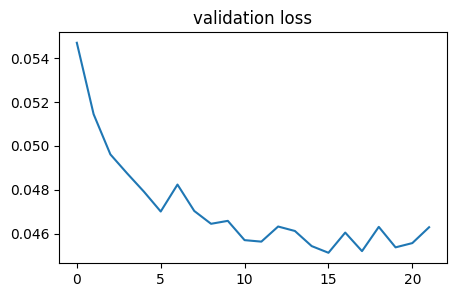

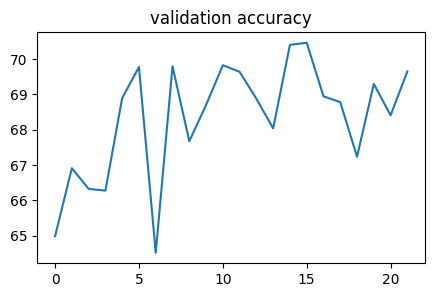

In [ ]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(22), lossv)
plt.title('validation loss')

plt.figure(figsize=(5,3))
plt.plot(np.arange(22), accv)
plt.title('validation accuracy');

In [ ]:
def predict(model, loader):
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(CUDA_DEV) for x in embeds]
            pred_logits = model(embeds)
            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

## fc

In [11]:
train_dataset1 = TaggingDataset(df_train)
test_dataset1 = TaggingDataset(df_test, True)

In [12]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWithoutBN(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class Net(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 512,
        hidden = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = Block(hidden, 512)
        self.lin_2 = Block(512, 1024)
        self.lin_3 = BlockWithoutBN(1024, 1200)
        self.lin_4 = Block(1200, 1580)
        self.lin_5 = BlockWithoutBN(1580, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.3)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

In [13]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration, data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss
            ))

In [14]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [15]:
train_dataloader1 = DataLoader(train_dataset1, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader1 = DataLoader(test_dataset1, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

In [16]:
model1 = Net().to('cuda')
criterion = nn.BCEWithLogitsLoss().to('cuda')
optimizer = torch.optim.Adam(model1.parameters(), lr=1e-4)
model1

Net(
  (bn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (projector): Linear(in_features=768, out_features=512, bias=True)
  (lin_1): Sequential(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_2): Sequential(
    (0): Linear(in_features=512, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_3): Sequential(
    (0): Linear(in_features=1024, out_features=1200, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (lin_4): Sequential(
    (0): Linear(in_features=1200, out_features=1580, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1580, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_5): Sequential(
    (0): Linear(in_features=1580, out_features=51

In [17]:
epochs = 23

for epoch in tqdm(range(epochs)):
    train_epoch(model1, train_dataloader1, criterion, optimizer)

  0%|          | 0/23 [00:00<?, ?it/s]

   2023-11-08 06:29:52.836815 batch 1 loss 0.7034427451814977
   2023-11-08 06:29:57.393551 batch 101 loss 0.0629217317998485
   2023-11-08 06:30:00.648669 batch 201 loss 0.062232130609155334
   2023-11-08 06:30:03.872518 batch 301 loss 0.05779792502034464
   2023-11-08 06:30:07.236119 batch 401 loss 0.06540788331012815
   2023-11-08 06:30:14.193004 batch 501 loss 0.05904557221912499
   2023-11-08 06:30:17.741691 batch 601 loss 0.05536297365071066
   2023-11-08 06:30:20.923311 batch 701 loss 0.050707689445432746


  4%|▍         | 1/23 [00:32<12:00, 32.77s/it]

   2023-11-08 06:30:24.436477 batch 1 loss 0.05454403283411055
   2023-11-08 06:30:28.652588 batch 101 loss 0.05172747761577687
   2023-11-08 06:30:31.807898 batch 201 loss 0.05108673701504467
   2023-11-08 06:30:34.960920 batch 301 loss 0.055263627686194916
   2023-11-08 06:30:38.373934 batch 401 loss 0.05393302995733412
   2023-11-08 06:30:42.592828 batch 501 loss 0.05613519205875116
   2023-11-08 06:30:45.819487 batch 601 loss 0.0484175198402024
   2023-11-08 06:30:49.004676 batch 701 loss 0.05341893738318919


  9%|▊         | 2/23 [01:00<10:29, 29.97s/it]

   2023-11-08 06:30:52.450225 batch 1 loss 0.048133506604587616
   2023-11-08 06:30:56.686267 batch 101 loss 0.04757765209964919
   2023-11-08 06:31:00.040920 batch 201 loss 0.04550043970481924
   2023-11-08 06:31:03.306980 batch 301 loss 0.05237725594524327
   2023-11-08 06:31:06.845896 batch 401 loss 0.04900780240020104
   2023-11-08 06:31:11.040019 batch 501 loss 0.052684352194097145
   2023-11-08 06:31:14.373672 batch 601 loss 0.05574258669123158
   2023-11-08 06:31:17.688860 batch 701 loss 0.052462408226411836


 13%|█▎        | 3/23 [01:29<09:49, 29.48s/it]

   2023-11-08 06:31:21.347338 batch 1 loss 0.047574875744199795
   2023-11-08 06:31:25.454856 batch 101 loss 0.048534178473484985
   2023-11-08 06:31:28.681436 batch 201 loss 0.0478213255943958
   2023-11-08 06:31:31.837282 batch 301 loss 0.0454075276565347
   2023-11-08 06:31:35.460306 batch 401 loss 0.04479995668617393
   2023-11-08 06:31:39.513541 batch 501 loss 0.047221078573623516
   2023-11-08 06:31:42.757205 batch 601 loss 0.044717631409108394
   2023-11-08 06:31:46.080088 batch 701 loss 0.04173717426868386


 17%|█▋        | 4/23 [01:58<09:12, 29.09s/it]

   2023-11-08 06:31:49.856358 batch 1 loss 0.04829915965574462
   2023-11-08 06:31:53.827486 batch 101 loss 0.05248685476484956
   2023-11-08 06:31:57.016592 batch 201 loss 0.04421701593971631
   2023-11-08 06:32:00.241377 batch 301 loss 0.04583017429857586
   2023-11-08 06:32:03.964125 batch 401 loss 0.046152961057423336
   2023-11-08 06:32:07.964082 batch 501 loss 0.04427029812112489
   2023-11-08 06:32:11.173254 batch 601 loss 0.04140396090386367
   2023-11-08 06:32:14.480655 batch 701 loss 0.04918223095883567


 22%|██▏       | 5/23 [02:26<08:40, 28.90s/it]

   2023-11-08 06:32:18.394076 batch 1 loss 0.04535785864688181
   2023-11-08 06:32:22.280107 batch 101 loss 0.038893575698762776
   2023-11-08 06:32:25.511557 batch 201 loss 0.05237166516968535
   2023-11-08 06:32:28.701100 batch 301 loss 0.04430816885944253
   2023-11-08 06:32:32.600541 batch 401 loss 0.05130449125453494
   2023-11-08 06:32:36.503436 batch 501 loss 0.044652277444654394
   2023-11-08 06:32:39.794510 batch 601 loss 0.04904913360981544
   2023-11-08 06:32:43.103698 batch 701 loss 0.05404108874942161


 26%|██▌       | 6/23 [02:55<08:11, 28.91s/it]

   2023-11-08 06:32:47.326286 batch 1 loss 0.03908593546498546
   2023-11-08 06:32:51.080564 batch 101 loss 0.050700309975812784
   2023-11-08 06:32:54.268163 batch 201 loss 0.04845781456098821
   2023-11-08 06:32:57.516823 batch 301 loss 0.047272346374253316
   2023-11-08 06:33:01.689986 batch 401 loss 0.05096654632776712
   2023-11-08 06:33:05.237516 batch 501 loss 0.04604291659305803
   2023-11-08 06:33:08.475328 batch 601 loss 0.047034607005148166
   2023-11-08 06:33:11.669488 batch 701 loss 0.04255743642386774


 30%|███       | 7/23 [03:24<07:41, 28.82s/it]

   2023-11-08 06:33:15.970939 batch 1 loss 0.04720976604591904
   2023-11-08 06:33:19.627296 batch 101 loss 0.04484856628530688
   2023-11-08 06:33:24.031571 batch 201 loss 0.042447269115245725
   2023-11-08 06:33:28.847232 batch 301 loss 0.05036572250940175
   2023-11-08 06:33:32.854869 batch 401 loss 0.04193160497197296
   2023-11-08 06:33:36.210323 batch 501 loss 0.04600594866115094
   2023-11-08 06:33:39.402075 batch 601 loss 0.04586935722543342
   2023-11-08 06:33:43.224945 batch 701 loss 0.04298931159677599


 35%|███▍      | 8/23 [03:55<07:23, 29.56s/it]

   2023-11-08 06:33:47.108286 batch 1 loss 0.0452120485846688
   2023-11-08 06:33:50.292972 batch 101 loss 0.04842549143342416
   2023-11-08 06:33:53.463002 batch 201 loss 0.04392230562209028
   2023-11-08 06:33:57.388603 batch 301 loss 0.04129031356652782
   2023-11-08 06:34:01.252163 batch 401 loss 0.04618320258212226
   2023-11-08 06:34:04.417331 batch 501 loss 0.04433810428430677
   2023-11-08 06:34:07.606542 batch 601 loss 0.04379662839212413
   2023-11-08 06:34:11.535489 batch 701 loss 0.047023048328909606


 39%|███▉      | 9/23 [04:23<06:47, 29.14s/it]

   2023-11-08 06:34:15.322211 batch 1 loss 0.04223387332290633
   2023-11-08 06:34:18.610560 batch 101 loss 0.044385126751850836
   2023-11-08 06:34:21.825712 batch 201 loss 0.04409748762594684
   2023-11-08 06:34:25.705796 batch 301 loss 0.04190991394796622
   2023-11-08 06:34:29.494861 batch 401 loss 0.04562197224490567
   2023-11-08 06:34:32.699875 batch 501 loss 0.041476432032047914
   2023-11-08 06:34:35.870581 batch 601 loss 0.045734429248916214
   2023-11-08 06:34:39.733750 batch 701 loss 0.04369351557542116


 43%|████▎     | 10/23 [04:51<06:15, 28.85s/it]

   2023-11-08 06:34:43.526062 batch 1 loss 0.04024569233789682
   2023-11-08 06:34:46.829131 batch 101 loss 0.04298856954265225
   2023-11-08 06:34:50.076053 batch 201 loss 0.042823548217167176
   2023-11-08 06:34:54.103024 batch 301 loss 0.039840559844686665
   2023-11-08 06:34:57.884981 batch 401 loss 0.045597958131654084
   2023-11-08 06:35:01.124851 batch 501 loss 0.04844586070806713
   2023-11-08 06:35:04.397135 batch 601 loss 0.04381101944356
   2023-11-08 06:35:08.451607 batch 701 loss 0.04006407715310666


 48%|████▊     | 11/23 [05:20<05:45, 28.76s/it]

   2023-11-08 06:35:12.101419 batch 1 loss 0.03917729350028824
   2023-11-08 06:35:15.317000 batch 101 loss 0.04081869339478584
   2023-11-08 06:35:18.561584 batch 201 loss 0.03930646075418587
   2023-11-08 06:35:22.574877 batch 301 loss 0.03625447543995652
   2023-11-08 06:35:26.301412 batch 401 loss 0.03863791645784737
   2023-11-08 06:35:29.461423 batch 501 loss 0.04229287705243497
   2023-11-08 06:35:32.661679 batch 601 loss 0.03862979477794071
   2023-11-08 06:35:36.653218 batch 701 loss 0.035688175923892715


 52%|█████▏    | 12/23 [05:48<05:14, 28.58s/it]

   2023-11-08 06:35:40.236613 batch 1 loss 0.039486816583319276
   2023-11-08 06:35:43.433272 batch 101 loss 0.03710140841800267
   2023-11-08 06:35:46.603787 batch 201 loss 0.04505648460401834
   2023-11-08 06:35:50.727056 batch 301 loss 0.036683160267258694
   2023-11-08 06:35:54.446339 batch 401 loss 0.04405443275375531
   2023-11-08 06:35:57.619815 batch 501 loss 0.03762760069305705
   2023-11-08 06:36:00.838132 batch 601 loss 0.04158091637905539
   2023-11-08 06:36:04.857466 batch 701 loss 0.040035979092993924


 57%|█████▋    | 13/23 [06:16<04:44, 28.47s/it]

   2023-11-08 06:36:08.459983 batch 1 loss 0.0377943544563531
   2023-11-08 06:36:11.632519 batch 101 loss 0.04745341207444606
   2023-11-08 06:36:14.853958 batch 201 loss 0.03995758925971303
   2023-11-08 06:36:18.919465 batch 301 loss 0.042731217058668156
   2023-11-08 06:36:22.648652 batch 401 loss 0.04391274078464035
   2023-11-08 06:36:25.838747 batch 501 loss 0.04001231109975956
   2023-11-08 06:36:29.082282 batch 601 loss 0.04355583081340603
   2023-11-08 06:36:33.098869 batch 701 loss 0.03851037139642191


 61%|██████    | 14/23 [06:45<04:15, 28.41s/it]

   2023-11-08 06:36:36.733449 batch 1 loss 0.04112583091602718
   2023-11-08 06:36:39.954663 batch 101 loss 0.0387156008688421
   2023-11-08 06:36:44.292810 batch 201 loss 0.03509726495695282
   2023-11-08 06:36:49.709855 batch 301 loss 0.042430140463201954
   2023-11-08 06:36:53.180874 batch 401 loss 0.036187756718792034
   2023-11-08 06:36:56.340929 batch 501 loss 0.038801630471729444
   2023-11-08 06:36:59.575635 batch 601 loss 0.045333131888470074
   2023-11-08 06:37:03.952341 batch 701 loss 0.037317975649175


 65%|██████▌   | 15/23 [07:15<03:52, 29.06s/it]

   2023-11-08 06:37:07.311118 batch 1 loss 0.03742893599664487
   2023-11-08 06:37:10.507568 batch 101 loss 0.03685535067981295
   2023-11-08 06:37:13.707169 batch 201 loss 0.03736590668371429
   2023-11-08 06:37:17.989309 batch 301 loss 0.04213059043930535
   2023-11-08 06:37:21.476238 batch 401 loss 0.04413482887151787
   2023-11-08 06:37:24.639043 batch 501 loss 0.0407394061960553
   2023-11-08 06:37:27.856911 batch 601 loss 0.04022918844815728
   2023-11-08 06:37:32.109467 batch 701 loss 0.03721252768987342


 70%|██████▉   | 16/23 [07:43<03:21, 28.79s/it]

   2023-11-08 06:37:35.453771 batch 1 loss 0.03478769627693035
   2023-11-08 06:37:38.699829 batch 101 loss 0.03621631255942148
   2023-11-08 06:37:41.874725 batch 201 loss 0.03582748546545377
   2023-11-08 06:37:46.115589 batch 301 loss 0.04002073070287474
   2023-11-08 06:37:49.593184 batch 401 loss 0.04139944497473934
   2023-11-08 06:37:52.867475 batch 501 loss 0.032987967339600695
   2023-11-08 06:37:56.038225 batch 601 loss 0.051874566883552756
   2023-11-08 06:38:00.340941 batch 701 loss 0.03495567970460478


 74%|███████▍  | 17/23 [08:12<02:51, 28.65s/it]

   2023-11-08 06:38:03.800317 batch 1 loss 0.03737589407428932
   2023-11-08 06:38:07.017257 batch 101 loss 0.0385587047583341
   2023-11-08 06:38:10.246167 batch 201 loss 0.03852370183642696
   2023-11-08 06:38:18.204278 batch 301 loss 0.03473592436289229
   2023-11-08 06:38:23.482389 batch 401 loss 0.03861261074281331
   2023-11-08 06:38:27.128649 batch 501 loss 0.04431938226779664
   2023-11-08 06:38:31.173987 batch 601 loss 0.043084505395695964
   2023-11-08 06:38:34.384041 batch 701 loss 0.0388931954998943


 78%|███████▊  | 18/23 [08:45<02:30, 30.18s/it]

   2023-11-08 06:38:37.536002 batch 1 loss 0.045050246428465335
   2023-11-08 06:38:41.149349 batch 101 loss 0.03888506494312698
   2023-11-08 06:38:45.388387 batch 201 loss 0.03623630524116893
   2023-11-08 06:38:48.606152 batch 301 loss 0.045343357632472256
   2023-11-08 06:38:51.779351 batch 401 loss 0.03473424425568859
   2023-11-08 06:38:55.456205 batch 501 loss 0.0382224688369134
   2023-11-08 06:38:59.580891 batch 601 loss 0.03875061150482628
   2023-11-08 06:39:02.864664 batch 701 loss 0.0424861307412944


 83%|████████▎ | 19/23 [09:14<01:58, 29.71s/it]

   2023-11-08 06:39:06.139881 batch 1 loss 0.03306287734317061
   2023-11-08 06:39:09.875244 batch 101 loss 0.03913843209374297
   2023-11-08 06:39:13.775252 batch 201 loss 0.0392693924535971
   2023-11-08 06:39:17.004215 batch 301 loss 0.035976277721058825
   2023-11-08 06:39:20.207995 batch 401 loss 0.03900700378715809
   2023-11-08 06:39:23.971265 batch 501 loss 0.03888209890853611
   2023-11-08 06:39:27.959278 batch 601 loss 0.040624737211449796
   2023-11-08 06:39:31.108900 batch 701 loss 0.03731291512144816


 87%|████████▋ | 20/23 [09:42<01:27, 29.22s/it]

   2023-11-08 06:39:34.220877 batch 1 loss 0.0373463101296281
   2023-11-08 06:39:37.848611 batch 101 loss 0.044189409103089314
   2023-11-08 06:39:41.905454 batch 201 loss 0.04139081301137902
   2023-11-08 06:39:45.926710 batch 301 loss 0.035127709391988005
   2023-11-08 06:39:49.116779 batch 401 loss 0.035441866229503904
   2023-11-08 06:39:53.079842 batch 501 loss 0.03527048446604659
   2023-11-08 06:39:56.777389 batch 601 loss 0.03072347319590813
   2023-11-08 06:39:59.934132 batch 701 loss 0.03972949806768686


 91%|█████████▏| 21/23 [10:11<00:58, 29.12s/it]

   2023-11-08 06:40:03.099110 batch 1 loss 0.038353663430938364
   2023-11-08 06:40:07.125937 batch 101 loss 0.037819594957969355
   2023-11-08 06:40:12.561626 batch 201 loss 0.040582950300661336
   2023-11-08 06:40:16.278402 batch 301 loss 0.0411795468923155
   2023-11-08 06:40:19.495217 batch 401 loss 0.035759239464920226
   2023-11-08 06:40:24.063214 batch 501 loss 0.04534913870190728
   2023-11-08 06:40:27.298153 batch 601 loss 0.04351331219657556
   2023-11-08 06:40:30.467202 batch 701 loss 0.03658654699369664


 96%|█████████▌| 22/23 [10:41<00:29, 29.53s/it]

   2023-11-08 06:40:33.595564 batch 1 loss 0.038924948613042035
   2023-11-08 06:40:38.118902 batch 101 loss 0.034861218312482775
   2023-11-08 06:40:41.288707 batch 201 loss 0.033072089610705645
   2023-11-08 06:40:44.459187 batch 301 loss 0.036438690386411975
   2023-11-08 06:40:47.626093 batch 401 loss 0.03610296504931091
   2023-11-08 06:40:52.054657 batch 501 loss 0.04522365248477422
   2023-11-08 06:40:55.262607 batch 601 loss 0.03835428630933922
   2023-11-08 06:40:58.387999 batch 701 loss 0.03760670988447902


100%|██████████| 23/23 [11:09<00:00, 29.13s/it]


## CNN 1d

In [18]:
train_dataset2 = TaggingDataset(df_train)
test_dataset2 = TaggingDataset(df_test, True)

In [19]:
class Cnn(nn.Module):
    def __init__(self, num_classes=NUM_TAGS, input_dim=768, hidden_dim=768):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels=512, out_channels=768, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=768, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv1d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(1024, 512, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv1d(512, 512, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(1024, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.projector =  nn.Linear(input_dim, 512)
        self.bn = nn.LayerNorm(512)
        self.skipper = nn.Conv1d(768, 512, kernel_size=3, stride=1, padding=1)

    def forward(self, embeds):
        x = [self.relu(self.projector(x)) for x in embeds]  # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x]  # 64,1,512
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x]  # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))]  # 64,2,512
        x = torch.stack(x_r, dim=0)  # 64,2,512
        x = self.bn(x)  # 64,2,512
        x = x.permute(0, 2, 1)

        x = self.relu(self.conv1(x))
        skip1 = self.skipper(x)
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = x + skip1
        skip2 = x
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = skip2 + x
        x = self.relu(self.conv5(x))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration, data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss
            ))

In [21]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [22]:
train_dataloader2 = DataLoader(train_dataset2, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader2 = DataLoader(test_dataset2, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

In [23]:
model2 = Cnn().to('cuda')
criterion = nn.BCEWithLogitsLoss().to('cuda')
optimizer = torch.optim.Adam(model2.parameters(), lr=1e-4)
model2

Cnn(
  (conv1): Conv1d(512, 768, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(768, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(1024, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv5): Conv1d(512, 512, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1024, out_features=768, bias=True)
  (fc2): Linear(in_features=768, out_features=256, bias=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (projector): Linear(in_features=768, out_features=512, bias=True)
  (bn): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (skipper): Conv1d(768, 512, kernel_size=(3,), stride=(1,), padding=(1,))
)

In [24]:
epochs = 23

for epoch in tqdm(range(epochs)):
    train_epoch(model2, train_dataloader2, criterion, optimizer)

  0%|          | 0/23 [00:00<?, ?it/s]

   2023-11-08 06:41:02.888696 batch 1 loss 0.6922724199879688
   2023-11-08 06:41:07.233943 batch 101 loss 0.06771785136599817
   2023-11-08 06:41:10.682518 batch 201 loss 0.06333489719997942
   2023-11-08 06:41:14.082157 batch 301 loss 0.06427002663260595
   2023-11-08 06:41:18.314068 batch 401 loss 0.061986399235613554
   2023-11-08 06:41:22.191109 batch 501 loss 0.05643615489649437
   2023-11-08 06:41:25.627660 batch 601 loss 0.0576120657694542
   2023-11-08 06:41:29.049112 batch 701 loss 0.05098719029858423


  4%|▍         | 1/23 [00:31<11:40, 31.82s/it]

   2023-11-08 06:41:33.595343 batch 1 loss 0.05550764925717146
   2023-11-08 06:41:37.120085 batch 101 loss 0.055620836880489674
   2023-11-08 06:41:40.570265 batch 201 loss 0.04954981087568128
   2023-11-08 06:41:44.068083 batch 301 loss 0.05518181482663302
   2023-11-08 06:41:48.723700 batch 401 loss 0.054291125962290056
   2023-11-08 06:41:52.118856 batch 501 loss 0.05173089140798552
   2023-11-08 06:41:55.570013 batch 601 loss 0.048999875002516444
   2023-11-08 06:41:59.432136 batch 701 loss 0.050168488857862195


  9%|▊         | 2/23 [01:01<10:46, 30.77s/it]

   2023-11-08 06:42:03.600342 batch 1 loss 0.04937551750372309
   2023-11-08 06:42:06.967209 batch 101 loss 0.05579947897352139
   2023-11-08 06:42:10.339976 batch 201 loss 0.048515112098004805
   2023-11-08 06:42:14.530968 batch 301 loss 0.050547654957094276
   2023-11-08 06:42:18.545966 batch 401 loss 0.05237856073854371
   2023-11-08 06:42:21.986408 batch 501 loss 0.04480699295866432
   2023-11-08 06:42:25.468886 batch 601 loss 0.05178592150509202
   2023-11-08 06:42:30.161022 batch 701 loss 0.04975702707971578


 13%|█▎        | 3/23 [01:31<10:09, 30.46s/it]

   2023-11-08 06:42:33.688835 batch 1 loss 0.041944743787747214
   2023-11-08 06:42:37.148394 batch 101 loss 0.049015773997928766
   2023-11-08 06:42:40.653775 batch 201 loss 0.05122482568039892
   2023-11-08 06:42:45.238287 batch 301 loss 0.048872502349076696
   2023-11-08 06:42:48.661566 batch 401 loss 0.0527286643896501
   2023-11-08 06:42:52.074851 batch 501 loss 0.045218307658825965
   2023-11-08 06:42:56.113138 batch 601 loss 0.04863964227908964
   2023-11-08 06:43:00.306292 batch 701 loss 0.04216628829163079


 17%|█▋        | 4/23 [02:02<09:36, 30.33s/it]

   2023-11-08 06:43:03.812101 batch 1 loss 0.04895190245588019
   2023-11-08 06:43:07.289278 batch 101 loss 0.04383819031573416
   2023-11-08 06:43:11.860288 batch 201 loss 0.041761301379721984
   2023-11-08 06:43:15.453248 batch 301 loss 0.04983089848410848
   2023-11-08 06:43:18.902665 batch 401 loss 0.047966832602511326
   2023-11-08 06:43:22.311103 batch 501 loss 0.05363642313706286
   2023-11-08 06:43:27.026924 batch 601 loss 0.04973797211312454
   2023-11-08 06:43:30.472478 batch 701 loss 0.05088364572621683


 22%|██▏       | 5/23 [02:33<09:12, 30.70s/it]

   2023-11-08 06:43:35.179298 batch 1 loss 0.04937010865472551
   2023-11-08 06:43:40.582964 batch 101 loss 0.050197735265059794
   2023-11-08 06:43:44.213575 batch 201 loss 0.049019014018784085
   2023-11-08 06:43:47.667168 batch 301 loss 0.04903782462031263
   2023-11-08 06:43:51.083987 batch 401 loss 0.045441826777713246
   2023-11-08 06:43:55.882069 batch 501 loss 0.042653714868727766
   2023-11-08 06:43:59.300527 batch 601 loss 0.04863411602473884
   2023-11-08 06:44:02.753928 batch 701 loss 0.043434622629852544


 26%|██▌       | 6/23 [03:04<08:45, 30.90s/it]

   2023-11-08 06:44:06.481593 batch 1 loss 0.04855440725571335
   2023-11-08 06:44:10.908230 batch 101 loss 0.050797565737487414
   2023-11-08 06:44:14.341362 batch 201 loss 0.047772040896890924
   2023-11-08 06:44:17.733519 batch 301 loss 0.04107856891268417
   2023-11-08 06:44:21.931377 batch 401 loss 0.043130723094463336
   2023-11-08 06:44:25.932955 batch 501 loss 0.04515992073306495
   2023-11-08 06:44:29.386104 batch 601 loss 0.051783120290930844
   2023-11-08 06:44:32.835323 batch 701 loss 0.04382706890265681


 30%|███       | 7/23 [03:35<08:14, 30.90s/it]

   2023-11-08 06:44:37.389773 batch 1 loss 0.0514148432811945
   2023-11-08 06:44:40.880262 batch 101 loss 0.04502504007546489
   2023-11-08 06:44:44.280039 batch 201 loss 0.04794253450575922
   2023-11-08 06:44:47.697405 batch 301 loss 0.05096090711654117
   2023-11-08 06:44:52.380461 batch 401 loss 0.044892918398385384
   2023-11-08 06:44:55.804713 batch 501 loss 0.04844326940908824
   2023-11-08 06:44:59.270301 batch 601 loss 0.04816448853722652
   2023-11-08 06:45:03.119935 batch 701 loss 0.04721142721711795


 35%|███▍      | 8/23 [04:05<07:39, 30.61s/it]

   2023-11-08 06:45:07.359944 batch 1 loss 0.04751219427830303
   2023-11-08 06:45:10.740281 batch 101 loss 0.04736133849051222
   2023-11-08 06:45:14.130778 batch 201 loss 0.0429028633144838
   2023-11-08 06:45:18.245951 batch 301 loss 0.05079291780746503
   2023-11-08 06:45:22.107450 batch 401 loss 0.04180557332245813
   2023-11-08 06:45:25.576055 batch 501 loss 0.048262561020238175
   2023-11-08 06:45:29.055641 batch 601 loss 0.042784334431130916
   2023-11-08 06:45:33.625356 batch 701 loss 0.047301206457173436


 39%|███▉      | 9/23 [04:35<07:04, 30.34s/it]

   2023-11-08 06:45:37.098574 batch 1 loss 0.03761527989165653
   2023-11-08 06:45:40.490032 batch 101 loss 0.04547433191444531
   2023-11-08 06:45:43.861374 batch 201 loss 0.04173493846512279
   2023-11-08 06:45:48.542537 batch 301 loss 0.04771146880609293
   2023-11-08 06:45:51.947553 batch 401 loss 0.047372456052822226
   2023-11-08 06:45:55.409508 batch 501 loss 0.05241936940109531
   2023-11-08 06:45:59.284325 batch 601 loss 0.047244594869482764
   2023-11-08 06:46:03.625841 batch 701 loss 0.04430481698009016


 43%|████▎     | 10/23 [05:05<06:32, 30.21s/it]

   2023-11-08 06:46:07.023480 batch 1 loss 0.03963330955112668
   2023-11-08 06:46:10.417658 batch 101 loss 0.04616593834444005
   2023-11-08 06:46:14.662148 batch 201 loss 0.045011859451700116
   2023-11-08 06:46:18.570723 batch 301 loss 0.047680489803376976
   2023-11-08 06:46:21.991869 batch 401 loss 0.042416860033277354
   2023-11-08 06:46:25.438221 batch 501 loss 0.04151470865764012
   2023-11-08 06:46:30.111196 batch 601 loss 0.042311062883462855
   2023-11-08 06:46:33.618952 batch 701 loss 0.040477003753098754


 48%|████▊     | 11/23 [05:35<06:01, 30.15s/it]

   2023-11-08 06:46:37.019503 batch 1 loss 0.039343634753459505
   2023-11-08 06:46:40.442935 batch 101 loss 0.043371517016710055
   2023-11-08 06:46:45.084417 batch 201 loss 0.050355356166144026
   2023-11-08 06:46:48.539757 batch 301 loss 0.04090099943502272
   2023-11-08 06:46:51.971261 batch 401 loss 0.047393625810296505
   2023-11-08 06:46:57.357670 batch 501 loss 0.0428457250533641
   2023-11-08 06:47:02.903433 batch 601 loss 0.03691305486740806
   2023-11-08 06:47:06.327414 batch 701 loss 0.04285627528153488


 52%|█████▏    | 12/23 [06:07<05:39, 30.90s/it]

   2023-11-08 06:47:09.634024 batch 1 loss 0.04555997641300796
   2023-11-08 06:47:13.993757 batch 101 loss 0.037538995231542485
   2023-11-08 06:47:17.706168 batch 201 loss 0.04089716512006071
   2023-11-08 06:47:21.104183 batch 301 loss 0.049355532776739305
   2023-11-08 06:47:24.560395 batch 401 loss 0.03516574333485509
   2023-11-08 06:47:29.242875 batch 501 loss 0.039205036523215546
   2023-11-08 06:47:32.687802 batch 601 loss 0.046908465667755875
   2023-11-08 06:47:36.080681 batch 701 loss 0.043467006204439655


 57%|█████▋    | 13/23 [06:37<05:06, 30.63s/it]

   2023-11-08 06:47:39.662149 batch 1 loss 0.03843921352317361
   2023-11-08 06:47:44.159382 batch 101 loss 0.044678146489104606
   2023-11-08 06:47:47.557592 batch 201 loss 0.04848163679649199
   2023-11-08 06:47:50.942397 batch 301 loss 0.03841728334972616
   2023-11-08 06:47:54.829621 batch 401 loss 0.0485402011814412
   2023-11-08 06:47:58.994890 batch 501 loss 0.04261165726888334
   2023-11-08 06:48:02.437026 batch 601 loss 0.04829690748706803
   2023-11-08 06:48:05.860767 batch 701 loss 0.039957199022193135


 61%|██████    | 14/23 [07:08<04:35, 30.57s/it]

   2023-11-08 06:48:10.089182 batch 1 loss 0.05073850689617751
   2023-11-08 06:48:13.955015 batch 101 loss 0.03734463324671193
   2023-11-08 06:48:17.431388 batch 201 loss 0.04617230683482079
   2023-11-08 06:48:20.965478 batch 301 loss 0.04567765945459805
   2023-11-08 06:48:25.762216 batch 401 loss 0.0454885702146311
   2023-11-08 06:48:29.189442 batch 501 loss 0.03681692786078432
   2023-11-08 06:48:32.628338 batch 601 loss 0.039924143581953744
   2023-11-08 06:48:36.332136 batch 701 loss 0.040194188050262765


 65%|██████▌   | 15/23 [07:38<04:04, 30.58s/it]

   2023-11-08 06:48:40.691571 batch 1 loss 0.03969484824080315
   2023-11-08 06:48:44.094713 batch 101 loss 0.03872001801064792
   2023-11-08 06:48:47.485870 batch 201 loss 0.045448720973287976
   2023-11-08 06:48:51.510635 batch 301 loss 0.043906758958756564
   2023-11-08 06:48:55.496769 batch 401 loss 0.03958878660843235
   2023-11-08 06:48:58.933848 batch 501 loss 0.04014955124579015
   2023-11-08 06:49:02.335422 batch 601 loss 0.041133835402105585
   2023-11-08 06:49:06.837572 batch 701 loss 0.04079034577791217


 70%|██████▉   | 16/23 [08:08<03:32, 30.32s/it]

   2023-11-08 06:49:10.384840 batch 1 loss 0.04310001115166594
   2023-11-08 06:49:13.706543 batch 101 loss 0.03874997025450272
   2023-11-08 06:49:17.145323 batch 201 loss 0.04186380495840847
   2023-11-08 06:49:21.771980 batch 301 loss 0.034404047617933135
   2023-11-08 06:49:25.160184 batch 401 loss 0.04186621762116874
   2023-11-08 06:49:28.642965 batch 501 loss 0.040466564194825014
   2023-11-08 06:49:32.268747 batch 601 loss 0.03365375380658092
   2023-11-08 06:49:36.723810 batch 701 loss 0.044243209584615695


 74%|███████▍  | 17/23 [08:38<03:00, 30.15s/it]

   2023-11-08 06:49:40.144233 batch 1 loss 0.038781409660285114
   2023-11-08 06:49:43.594983 batch 101 loss 0.044552812117282695
   2023-11-08 06:49:47.677038 batch 201 loss 0.04019772862071623
   2023-11-08 06:49:51.717800 batch 301 loss 0.041860726163706743
   2023-11-08 06:49:55.154208 batch 401 loss 0.03792188648525621
   2023-11-08 06:49:58.550283 batch 501 loss 0.039944076704983206
   2023-11-08 06:50:03.023788 batch 601 loss 0.03891880072934803
   2023-11-08 06:50:06.714106 batch 701 loss 0.03139411909259798


 78%|███████▊  | 18/23 [09:08<02:30, 30.09s/it]

   2023-11-08 06:50:10.091458 batch 1 loss 0.04266454784183782
   2023-11-08 06:50:13.490258 batch 101 loss 0.03842248874447692
   2023-11-08 06:50:19.732201 batch 201 loss 0.040511965931548946
   2023-11-08 06:50:24.087046 batch 301 loss 0.04101456164890473
   2023-11-08 06:50:27.534656 batch 401 loss 0.04044394155289273
   2023-11-08 06:50:31.529177 batch 501 loss 0.042793880868832734
   2023-11-08 06:50:35.571891 batch 601 loss 0.03404152303736834
   2023-11-08 06:50:38.951824 batch 701 loss 0.04041666617112241


 83%|████████▎ | 19/23 [09:40<02:02, 30.75s/it]

   2023-11-08 06:50:42.367965 batch 1 loss 0.039538859303870875
   2023-11-08 06:50:46.647760 batch 101 loss 0.041141711313744056
   2023-11-08 06:50:50.310584 batch 201 loss 0.03181464276840515
   2023-11-08 06:50:53.739325 batch 301 loss 0.03579733103841542
   2023-11-08 06:50:57.132107 batch 401 loss 0.037008538149242556
   2023-11-08 06:51:01.891530 batch 501 loss 0.04687669365837683
   2023-11-08 06:51:05.341754 batch 601 loss 0.039513123419036025
   2023-11-08 06:51:08.732321 batch 701 loss 0.03297896864677004


 87%|████████▋ | 20/23 [10:10<01:31, 30.49s/it]

   2023-11-08 06:51:12.267298 batch 1 loss 0.0375279228370031
   2023-11-08 06:51:16.785339 batch 101 loss 0.036920122183956204
   2023-11-08 06:51:20.203198 batch 201 loss 0.03670535185715973
   2023-11-08 06:51:23.658798 batch 301 loss 0.041110346345832494
   2023-11-08 06:51:27.671349 batch 401 loss 0.03369506276288173
   2023-11-08 06:51:31.741815 batch 501 loss 0.039907446796724345
   2023-11-08 06:51:35.117370 batch 601 loss 0.03437051024722661
   2023-11-08 06:51:38.487205 batch 701 loss 0.03885116283760466


 91%|█████████▏| 21/23 [10:40<01:00, 30.47s/it]

   2023-11-08 06:51:42.701609 batch 1 loss 0.03323139744790206
   2023-11-08 06:51:46.536859 batch 101 loss 0.03700955325363174
   2023-11-08 06:51:49.874934 batch 201 loss 0.03193718038397422
   2023-11-08 06:51:53.228540 batch 301 loss 0.03639213301878491
   2023-11-08 06:51:57.854102 batch 401 loss 0.033446491804094106
   2023-11-08 06:52:01.255804 batch 501 loss 0.03755159830011787
   2023-11-08 06:52:04.719858 batch 601 loss 0.04193379736169624
   2023-11-08 06:52:08.177220 batch 701 loss 0.036268880046391436


 96%|█████████▌| 22/23 [11:10<00:30, 30.33s/it]

   2023-11-08 06:52:12.700826 batch 1 loss 0.03869256990144766
   2023-11-08 06:52:16.176499 batch 101 loss 0.03697961972231226
   2023-11-08 06:52:19.569183 batch 201 loss 0.03901474491943638
   2023-11-08 06:52:23.366262 batch 301 loss 0.033541282380765175
   2023-11-08 06:52:27.680055 batch 401 loss 0.03514781439562299
   2023-11-08 06:52:31.128383 batch 501 loss 0.03828820572220918
   2023-11-08 06:52:34.568275 batch 601 loss 0.04160456361404261
   2023-11-08 06:52:38.867994 batch 701 loss 0.03113731026396961


100%|██████████| 23/23 [11:40<00:00, 30.48s/it]


## LSTM

In [25]:
train_dataset3 = TaggingDataset(df_train)
test_dataset3 = TaggingDataset(df_test, True)

In [26]:
def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWithoutBN(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )

class LSTMNet(nn.Module):
    def __init__(self, input_size=768, hidden_size=768, num_classes=256):
        super().__init__()
        self.num_classes = num_classes
        self.lin_1 = Block(512, 768)
        self.lin_2 = Block(768, 950)
        self.lin_3 = BlockWithoutBN(950, 1150)
        self.lin_4 = Block(1150, 1259)
        self.lin_5 = BlockWithoutBN(1259, 768)
        self.fc = nn.Linear(768, num_classes)
        self.drop = nn.Dropout(0.3)

        self.relu = nn.LeakyReLU()
        self.projector =  nn.Linear(input_size, 512)
        self.bn = nn.LayerNorm(512)
        self.lstms = nn.ModuleList([nn.LSTM(512, 512, batch_first=True, bidirectional=True) for _ in range(2)])

    def forward(self, embeds):
        # 64,X,768
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [v.std(dim=0).unsqueeze(0) for v in x]  # 64,1,512 --> v.size = X,512 --> we apply std by columns (512) and add dim (1,512)

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = self.bn(x)  # 64,2,512

        k = 0
        for lstm in self.lstms:
            x, (hn, cn) = lstm(x)
            if k == 1:
              x = hn[-1]
            else:
              x = hn[-1].unsqueeze(1)
            k += 1
        # x.size() = 64,512
        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

In [27]:
def train_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = None
    alpha = 0.8
    for iteration, data in enumerate(loader):
        optimizer.zero_grad()
        track_idxs, embeds, target = data
        embeds = [x.to(CUDA_DEV) for x in embeds]
        target = target.to(CUDA_DEV)
        pred_logits = model(embeds)
        pred_probs = torch.sigmoid(pred_logits)
        ce_loss = criterion(pred_logits, target)
        ce_loss.backward()
        optimizer.step()

        if running_loss is None:
            running_loss = ce_loss.item()
        else:
            running_loss = alpha * ce_loss.item() + (1 - alpha) * ce_loss.item()
        if iteration % 100 == 0:
            print('   {} batch {} loss {}'.format(
                datetime.now(), iteration + 1, running_loss
            ))

In [28]:
def collate_fn(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    targets = np.vstack([x[2] for x in b])
    targets = torch.from_numpy(targets)
    return track_idxs, embeds, targets

def collate_fn_test(b):
    track_idxs = torch.from_numpy(np.vstack([x[0] for x in b]))
    embeds = [x[1] for x in b]
    return track_idxs, embeds

In [29]:
train_dataloader3 = DataLoader(train_dataset3, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_dataloader3 = DataLoader(test_dataset3, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

In [30]:
model3 = LSTMNet().to('cuda')
criterion = nn.BCEWithLogitsLoss().to('cuda')
optimizer = torch.optim.AdamW(model3.parameters(), lr=3e-4)
model3

LSTMNet(
  (lin_1): Sequential(
    (0): Linear(in_features=512, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_2): Sequential(
    (0): Linear(in_features=768, out_features=950, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(950, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_3): Sequential(
    (0): Linear(in_features=950, out_features=1150, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (lin_4): Sequential(
    (0): Linear(in_features=1150, out_features=1259, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(1259, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (lin_5): Sequential(
    (0): Linear(in_features=1259, out_features=768, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (fc): Linear(in_features=768, out_features=256, bias=True)
  (drop): 

In [31]:
epochs = 23

for epoch in tqdm(range(epochs)):
    train_epoch(model3, train_dataloader3, criterion, optimizer)

  0%|          | 0/23 [00:00<?, ?it/s]

   2023-11-08 06:52:43.130359 batch 1 loss 0.7082560792926458
   2023-11-08 06:52:47.123095 batch 101 loss 0.06037879955323788
   2023-11-08 06:52:51.504854 batch 201 loss 0.0563689181764471
   2023-11-08 06:52:56.398300 batch 301 loss 0.05888789755495907
   2023-11-08 06:53:00.364158 batch 401 loss 0.05581430107167983
   2023-11-08 06:53:04.387452 batch 501 loss 0.05701794634983423
   2023-11-08 06:53:09.549190 batch 601 loss 0.05374142645618296
   2023-11-08 06:53:13.432988 batch 701 loss 0.05438843976638345


  4%|▍         | 1/23 [00:34<12:36, 34.39s/it]

   2023-11-08 06:53:17.307185 batch 1 loss 0.05203575710501107
   2023-11-08 06:53:22.550186 batch 101 loss 0.05130054521445937
   2023-11-08 06:53:26.453975 batch 201 loss 0.05396710202596487
   2023-11-08 06:53:30.431466 batch 301 loss 0.043921479524710025
   2023-11-08 06:53:35.247951 batch 401 loss 0.05527231335011763
   2023-11-08 06:53:40.982680 batch 501 loss 0.04623566576720918
   2023-11-08 06:53:45.418079 batch 601 loss 0.04808729364150648
   2023-11-08 06:53:50.629393 batch 701 loss 0.051914232415346


  9%|▊         | 2/23 [01:11<12:37, 36.05s/it]

   2023-11-08 06:53:54.522054 batch 1 loss 0.047248678788000716
   2023-11-08 06:53:58.475321 batch 101 loss 0.05093850897195443
   2023-11-08 06:54:03.235835 batch 201 loss 0.05107421243713045
   2023-11-08 06:54:07.661230 batch 301 loss 0.05166890280966965
   2023-11-08 06:54:11.575159 batch 401 loss 0.04905247495474323
   2023-11-08 06:54:15.921654 batch 501 loss 0.0519822306467346
   2023-11-08 06:54:20.626172 batch 601 loss 0.052359718212080186
   2023-11-08 06:54:24.564370 batch 701 loss 0.050034360688587964


 13%|█▎        | 3/23 [01:45<11:41, 35.07s/it]

   2023-11-08 06:54:28.436629 batch 1 loss 0.044864087636963076
   2023-11-08 06:54:33.610203 batch 101 loss 0.049731418543959724
   2023-11-08 06:54:37.623621 batch 201 loss 0.050888277273744606
   2023-11-08 06:54:41.554596 batch 301 loss 0.0524246586109089
   2023-11-08 06:54:46.796985 batch 401 loss 0.049636151865014105
   2023-11-08 06:54:50.744195 batch 501 loss 0.05365804612214087
   2023-11-08 06:54:54.650737 batch 601 loss 0.048164489652210096
   2023-11-08 06:54:59.338664 batch 701 loss 0.04254180247797927


 17%|█▋        | 4/23 [02:20<11:08, 35.16s/it]

   2023-11-08 06:55:03.752071 batch 1 loss 0.04712316175216212
   2023-11-08 06:55:07.725159 batch 101 loss 0.042166576057539214
   2023-11-08 06:55:11.961943 batch 201 loss 0.04984662684375925
   2023-11-08 06:55:16.843265 batch 301 loss 0.053972930012598105
   2023-11-08 06:55:20.768612 batch 401 loss 0.04380222779788766
   2023-11-08 06:55:24.697816 batch 501 loss 0.044628099585580304
   2023-11-08 06:55:29.922401 batch 601 loss 0.04733720901568541
   2023-11-08 06:55:33.970715 batch 701 loss 0.04814561643291761


 22%|██▏       | 5/23 [02:55<10:26, 34.82s/it]

   2023-11-08 06:55:37.937099 batch 1 loss 0.047386418295660385
   2023-11-08 06:55:43.128023 batch 101 loss 0.047621700367142736
   2023-11-08 06:55:47.094364 batch 201 loss 0.04654817933607826
   2023-11-08 06:55:51.018919 batch 301 loss 0.04250029212598781
   2023-11-08 06:55:55.696307 batch 401 loss 0.04511987269727179
   2023-11-08 06:56:00.080621 batch 501 loss 0.04815405495959091
   2023-11-08 06:56:04.085656 batch 601 loss 0.048537186893763316
   2023-11-08 06:56:08.427907 batch 701 loss 0.04827884517432879


 26%|██▌       | 6/23 [03:30<09:54, 34.97s/it]

   2023-11-08 06:56:13.223170 batch 1 loss 0.0499154198995438
   2023-11-08 06:56:17.276673 batch 101 loss 0.04495980108082624
   2023-11-08 06:56:21.240496 batch 201 loss 0.045266059649666346
   2023-11-08 06:56:26.455236 batch 301 loss 0.04507096922560947
   2023-11-08 06:56:30.448323 batch 401 loss 0.04380986774213043
   2023-11-08 06:56:34.472994 batch 501 loss 0.04154598639406928
   2023-11-08 06:56:39.677867 batch 601 loss 0.0433336848954617
   2023-11-08 06:56:43.593732 batch 701 loss 0.04597824298459385


 30%|███       | 7/23 [04:04<09:15, 34.74s/it]

   2023-11-08 06:56:47.484117 batch 1 loss 0.05070525076834733
   2023-11-08 06:56:52.306077 batch 101 loss 0.04279351861420343
   2023-11-08 06:56:56.604828 batch 201 loss 0.043012599824219115
   2023-11-08 06:57:00.570684 batch 301 loss 0.040925694218025985
   2023-11-08 06:57:05.059449 batch 401 loss 0.04787079396801468
   2023-11-08 06:57:11.049519 batch 501 loss 0.038351349600569754
   2023-11-08 06:57:15.746343 batch 601 loss 0.04479357292010928
   2023-11-08 06:57:20.501206 batch 701 loss 0.044958236964842066


 35%|███▍      | 8/23 [04:41<08:53, 35.59s/it]

   2023-11-08 06:57:24.888214 batch 1 loss 0.0420987076967054
   2023-11-08 06:57:28.843836 batch 101 loss 0.04774869439808747
   2023-11-08 06:57:33.302055 batch 201 loss 0.045131712756903225
   2023-11-08 06:57:38.091809 batch 301 loss 0.04985520975447196
   2023-11-08 06:57:42.082772 batch 401 loss 0.04083968442281946
   2023-11-08 06:57:46.186852 batch 501 loss 0.046619541893888616
   2023-11-08 06:57:51.305509 batch 601 loss 0.049747861998236546
   2023-11-08 06:57:55.280327 batch 701 loss 0.05166951113882132


 39%|███▉      | 9/23 [05:16<08:12, 35.19s/it]

   2023-11-08 06:57:59.200190 batch 1 loss 0.04014241161303063
   2023-11-08 06:58:04.419380 batch 101 loss 0.04693814007959117
   2023-11-08 06:58:08.338684 batch 201 loss 0.042789220427956375
   2023-11-08 06:58:12.286746 batch 301 loss 0.04730285655021813
   2023-11-08 06:58:17.262061 batch 401 loss 0.046481922583915744
   2023-11-08 06:58:21.406250 batch 501 loss 0.04816283071003523
   2023-11-08 06:58:25.431069 batch 601 loss 0.04218373784342707
   2023-11-08 06:58:29.978726 batch 701 loss 0.04934182687469198


 43%|████▎     | 10/23 [05:51<07:38, 35.24s/it]

   2023-11-08 06:58:34.555602 batch 1 loss 0.037586118679147434
   2023-11-08 06:58:38.584996 batch 101 loss 0.04336988234600894
   2023-11-08 06:58:42.866653 batch 201 loss 0.040575329604773336
   2023-11-08 06:58:47.836754 batch 301 loss 0.04649619875091294
   2023-11-08 06:58:51.779923 batch 401 loss 0.042988331833576296
   2023-11-08 06:58:55.829721 batch 501 loss 0.04389691055536744
   2023-11-08 06:59:00.998673 batch 601 loss 0.04966570066385371
   2023-11-08 06:59:04.975739 batch 701 loss 0.04225415731053666


 48%|████▊     | 11/23 [06:25<06:59, 34.96s/it]

   2023-11-08 06:59:08.894666 batch 1 loss 0.04410143173567528
   2023-11-08 06:59:14.029582 batch 101 loss 0.043736842995604285
   2023-11-08 06:59:17.994965 batch 201 loss 0.04657345477065705
   2023-11-08 06:59:21.901503 batch 301 loss 0.04176104428071467
   2023-11-08 06:59:26.518333 batch 401 loss 0.04186988962692786
   2023-11-08 06:59:30.947136 batch 501 loss 0.03613906102194983
   2023-11-08 06:59:34.882121 batch 601 loss 0.04244655744868042
   2023-11-08 06:59:39.213065 batch 701 loss 0.05410419743678459


 52%|█████▏    | 12/23 [07:01<06:25, 35.02s/it]

   2023-11-08 06:59:44.047858 batch 1 loss 0.044997686220350136
   2023-11-08 06:59:48.042402 batch 101 loss 0.04010685134276232
   2023-11-08 06:59:51.991282 batch 201 loss 0.03428518791254394
   2023-11-08 06:59:57.209478 batch 301 loss 0.04132928153123747
   2023-11-08 07:00:01.206880 batch 401 loss 0.043978902938738254
   2023-11-08 07:00:05.204776 batch 501 loss 0.040813473952147614
   2023-11-08 07:00:10.462553 batch 601 loss 0.038960577169064314
   2023-11-08 07:00:14.469477 batch 701 loss 0.04148528941447732


 57%|█████▋    | 13/23 [07:35<05:48, 34.82s/it]

   2023-11-08 07:00:18.391320 batch 1 loss 0.039613651487960845
   2023-11-08 07:00:23.439283 batch 101 loss 0.046823072179574564
   2023-11-08 07:00:27.654871 batch 201 loss 0.046255803520669894
   2023-11-08 07:00:31.591088 batch 301 loss 0.04484345486456606
   2023-11-08 07:00:36.220670 batch 401 loss 0.04457152436425567
   2023-11-08 07:00:42.002600 batch 501 loss 0.03908706923862365
   2023-11-08 07:00:46.822978 batch 601 loss 0.03981756188668648
   2023-11-08 07:00:51.951212 batch 701 loss 0.043028653938174566


 61%|██████    | 14/23 [08:12<05:20, 35.64s/it]

   2023-11-08 07:00:55.917905 batch 1 loss 0.042704812239974306
   2023-11-08 07:00:59.874900 batch 101 loss 0.04585493004450858
   2023-11-08 07:01:04.669435 batch 201 loss 0.04424119922884338
   2023-11-08 07:01:09.111695 batch 301 loss 0.03943118250017939
   2023-11-08 07:01:13.104662 batch 401 loss 0.03710928857194397
   2023-11-08 07:01:17.568912 batch 501 loss 0.0412068431912854
   2023-11-08 07:01:22.351716 batch 601 loss 0.04131780444508475
   2023-11-08 07:01:26.298353 batch 701 loss 0.042335248264842695


 65%|██████▌   | 15/23 [08:47<04:41, 35.23s/it]

   2023-11-08 07:01:30.236763 batch 1 loss 0.04127960087362937
   2023-11-08 07:01:35.599422 batch 101 loss 0.04628864750450715
   2023-11-08 07:01:39.606573 batch 201 loss 0.041270544003006684
   2023-11-08 07:01:43.569210 batch 301 loss 0.043078188994771685
   2023-11-08 07:01:49.095057 batch 401 loss 0.03565335831691234
   2023-11-08 07:01:53.156581 batch 501 loss 0.04726168731964636
   2023-11-08 07:01:57.207905 batch 601 loss 0.035603563565598
   2023-11-08 07:02:02.366819 batch 701 loss 0.041246655158351256


 70%|██████▉   | 16/23 [09:23<04:08, 35.56s/it]

   2023-11-08 07:02:06.555276 batch 1 loss 0.03934190879342676
   2023-11-08 07:02:10.572457 batch 101 loss 0.042265249069974135
   2023-11-08 07:02:15.425466 batch 201 loss 0.04174623401857237
   2023-11-08 07:02:19.833354 batch 301 loss 0.040809202029038316
   2023-11-08 07:02:23.852904 batch 401 loss 0.04668015462328948
   2023-11-08 07:02:28.395127 batch 501 loss 0.04197568747433094
   2023-11-08 07:02:33.031293 batch 601 loss 0.04114083750296577
   2023-11-08 07:02:36.942606 batch 701 loss 0.04121424240023873


 74%|███████▍  | 17/23 [09:58<03:31, 35.22s/it]

   2023-11-08 07:02:40.995486 batch 1 loss 0.04414015285381204
   2023-11-08 07:02:46.131555 batch 101 loss 0.037901115926545714
   2023-11-08 07:02:50.077216 batch 201 loss 0.03898653015941335
   2023-11-08 07:02:54.031053 batch 301 loss 0.044871197369988944
   2023-11-08 07:02:59.199741 batch 401 loss 0.04858043854227513
   2023-11-08 07:03:03.180455 batch 501 loss 0.04475371958098501
   2023-11-08 07:03:07.124398 batch 601 loss 0.03762314881289072
   2023-11-08 07:03:12.075274 batch 701 loss 0.042421423823498304


 78%|███████▊  | 18/23 [10:33<02:56, 35.25s/it]

   2023-11-08 07:03:16.303985 batch 1 loss 0.040709972285013864
   2023-11-08 07:03:20.286125 batch 101 loss 0.03950060557591787
   2023-11-08 07:03:24.827205 batch 201 loss 0.046476108044372716
   2023-11-08 07:03:29.462252 batch 301 loss 0.0386138202243579
   2023-11-08 07:03:33.428721 batch 401 loss 0.04161179478164948
   2023-11-08 07:03:37.666029 batch 501 loss 0.03947489764405558
   2023-11-08 07:03:42.643899 batch 601 loss 0.038122624930252536
   2023-11-08 07:03:46.705879 batch 701 loss 0.040545722524038874


 83%|████████▎ | 19/23 [11:07<02:19, 34.99s/it]

   2023-11-08 07:03:50.673031 batch 1 loss 0.039098359778137685
   2023-11-08 07:03:55.966023 batch 101 loss 0.038465439974663694
   2023-11-08 07:03:59.962890 batch 201 loss 0.04030204639043683
   2023-11-08 07:04:03.909433 batch 301 loss 0.04158251245146549
   2023-11-08 07:04:09.323938 batch 401 loss 0.03955965010471422
   2023-11-08 07:04:15.148352 batch 501 loss 0.040636763167846826
   2023-11-08 07:04:19.086260 batch 601 loss 0.037741303034577775
   2023-11-08 07:04:24.292430 batch 701 loss 0.03711432518337181


 87%|████████▋ | 20/23 [11:45<01:47, 35.80s/it]

   2023-11-08 07:04:28.379397 batch 1 loss 0.046351967317077206
   2023-11-08 07:04:32.442885 batch 101 loss 0.044780495611348774
   2023-11-08 07:04:37.746341 batch 201 loss 0.040555249330381626
   2023-11-08 07:04:41.758148 batch 301 loss 0.04295230468306767
   2023-11-08 07:04:45.789373 batch 401 loss 0.03782130511058018
   2023-11-08 07:04:50.816467 batch 501 loss 0.04085698381707385
   2023-11-08 07:04:55.023633 batch 601 loss 0.03907401328615645
   2023-11-08 07:04:59.049226 batch 701 loss 0.04391883187359671


 91%|█████████▏| 21/23 [12:20<01:11, 35.66s/it]

   2023-11-08 07:05:03.718652 batch 1 loss 0.04692006492081874
   2023-11-08 07:05:08.333607 batch 101 loss 0.03788994576583406
   2023-11-08 07:05:12.280936 batch 201 loss 0.03907348136259457
   2023-11-08 07:05:17.503478 batch 301 loss 0.04122037099484607
   2023-11-08 07:05:22.250906 batch 401 loss 0.04435897980475345
   2023-11-08 07:05:26.209351 batch 501 loss 0.035674588585824854
   2023-11-08 07:05:30.280634 batch 601 loss 0.03661719119295178
   2023-11-08 07:05:35.324430 batch 701 loss 0.03792543729897391


 96%|█████████▌| 22/23 [12:56<00:35, 35.63s/it]

   2023-11-08 07:05:39.271042 batch 1 loss 0.046623628720589894
   2023-11-08 07:05:43.261118 batch 101 loss 0.03863301354142888
   2023-11-08 07:05:48.460234 batch 201 loss 0.039371053092979426
   2023-11-08 07:05:52.425983 batch 301 loss 0.040981136505076864
   2023-11-08 07:05:56.392912 batch 401 loss 0.04044747659947962
   2023-11-08 07:06:01.634621 batch 501 loss 0.03992034950049177
   2023-11-08 07:06:05.821646 batch 601 loss 0.04347115286652248
   2023-11-08 07:06:09.785556 batch 701 loss 0.040041608206203796


100%|██████████| 23/23 [13:31<00:00, 35.29s/it]


## Solution

In [42]:
test_dataset = TaggingDataset(df_test, True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn_test)

In [43]:
def predict(models, loader):
    model1, model2, model3 = models
    model1.eval()
    model2.eval()
    model3.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(CUDA_DEV) for x in embeds]

            # stacking with weights (depends on impact of model)
            k1 = 1
            k2 = 0.85
            k3 = 0.85
            pred_logits = (k1 * model1(embeds) + k2 * model2(embeds) + k3 * model3(embeds)) / 3

            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

In [44]:
track_idxs, predictions = predict((model1, model2, model3), test_dataloader)

In [45]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])

In [46]:
predictions_df.to_csv('prediction.csv', index=False)

## топ решения

In [ ]:
# 0.252
# 21 epochs

def Block(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU(),
        nn.BatchNorm1d(channels_out),
    )

def BlockWithoutBN(channels_in, channels_out):
    return nn.Sequential(
        nn.Linear(channels_in, channels_out),
        nn.LeakyReLU()
    )


class Net(nn.Module):
    def __init__(
        self,
        num_classes = NUM_TAGS,
        input_dim = 768,
        hidden_dim = 512,
        hidden = 512
    ):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin_1 = Block(hidden, 512)
        self.lin_2 = Block(512, 1024)
        self.lin_3 = BlockWithoutBN(1024, 1200)
        self.lin_4 = Block(1200, 1580)
        self.lin_5 = BlockWithoutBN(1580, hidden_dim)
        self.fc = nn.Linear(hidden_dim, num_classes)
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(0.2)


    def forward(self, embeds):
        # 64,X,512
        x = [self.relu(self.projector(x)) for x in embeds] # 64,X,512

        x_1 = [v.mean(0).unsqueeze(0) for v in x] # 64,1,512  --> v.size = X,512 --> we apply mean by columns (512) and add dim (1,512)
        x_2 = [torch.exp(v).mean(dim=0).unsqueeze(0) for v in x] # 64,1,512

        x_r = [torch.cat((x_1[i], x_2[i]), 0) for i in range(len(x))] # 64,2,512
        x = torch.stack(x_r, dim=0) # 64,2,512
        x = x.mean(dim=1) # 64,512
        x = self.bn(x) # 64,512

        x = self.lin_1(x)
        x = self.lin_2(x)
        x = self.drop(x)
        x = self.lin_3(x)
        x = self.lin_4(x)
        x = self.drop(x)
        x = self.lin_5(x)
        outs = self.fc(x)
        return outs

## pca

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
track_idx, embeds, target = train_dataset[0]
emb = embeds[:10].to("cpu:0")

In [ ]:
def print_target(target):
  # Получите индексы с ненулевыми значениями
  nonzero_indices = np.nonzero(target)

  # nonzero_indices - это кортеж с двумя массивами: один для индексов строк и другой для индексов столбцов
  row_indices = nonzero_indices

  # Выведите индексы с ненулевыми значениями
  for i in range(len(row_indices)):
      print(f"Row: {row_indices[i]}")

In [ ]:
# best ones
mean_batch = torch.log(emb.abs() + 1e-6).std(dim=1).to('cpu')
mean_batch = torch.sqrt(torch.mean(emb**2, dim=1)).to('cpu')

mean_batch = np.correlate(emb[0].cpu().numpy(), emb[0].cpu().numpy(), mode='full')
data_array = data



In [ ]:
def print_subplots(emb):
  # Your data as a tensor (assuming 'data' is your tensor)
  mean_batch = torch.sqrt(torch.mean(emb**2, dim=1)).to('cpu')
  data = mean_batch
  print(data.size())

  # Convert the tensor to a NumPy array
  data_array = data.numpy()

  # Create a list of indices for x-axis
  indices = list(range(len(data_array)))

  # Create a scatter plot
  plt.scatter(indices, data_array, marker='o', s=10)  # 'o' represents the marker style, and 's' sets the marker size

  # Set labels and title
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Distribution of Points')

  # Show the plot
  plt.show()

torch.Size([74])


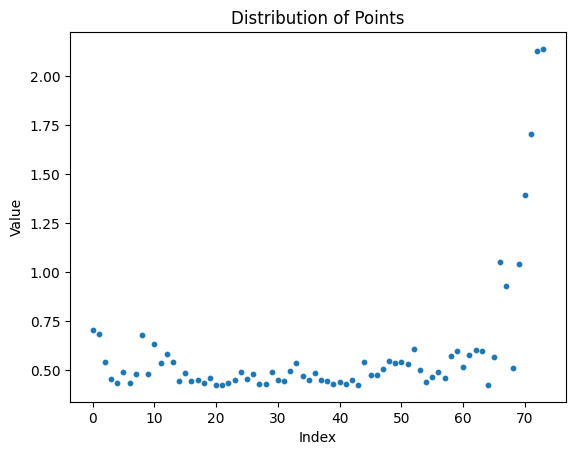

Row: [ 5  6  9 26 32 55 96]
torch.Size([59])


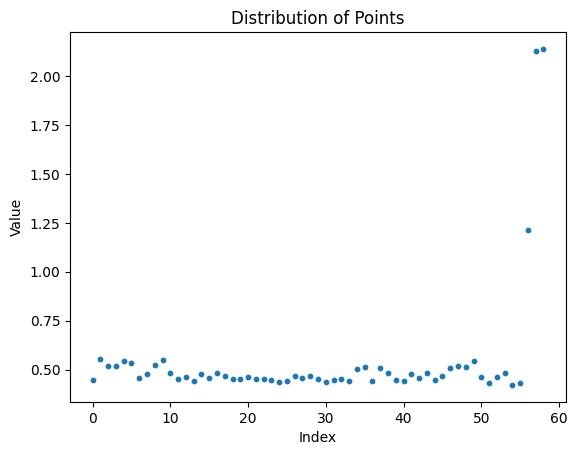

Row: [  6   9  28  39 145 155]
torch.Size([74])


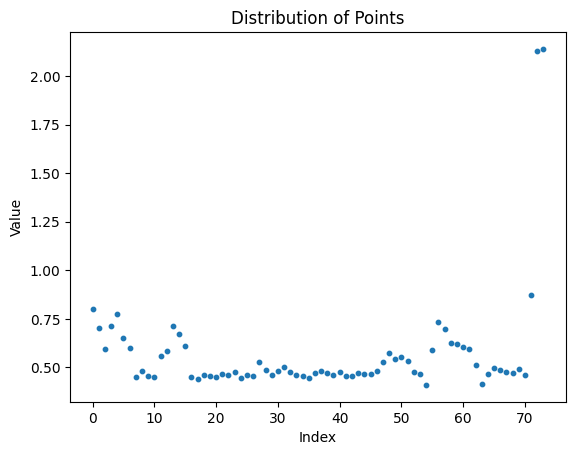

Row: [  0   6  28  40 116 168]
torch.Size([54])


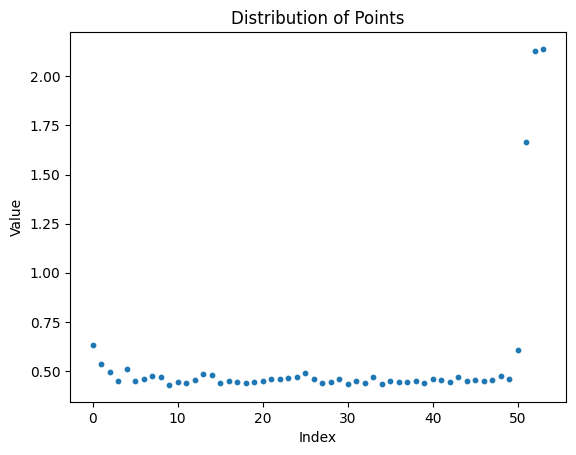

Row: [ 28 186]
torch.Size([27])


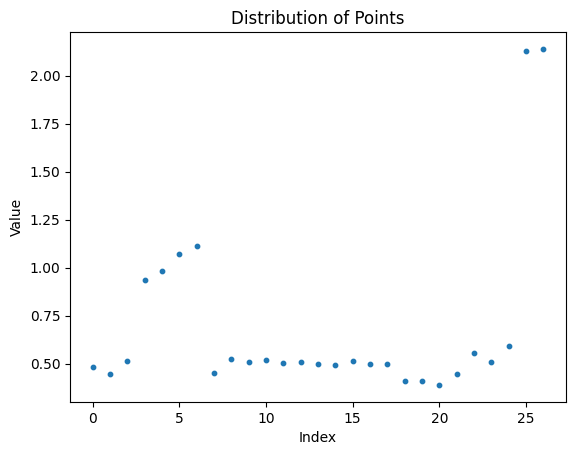

Row: [  6  23 177]
torch.Size([65])


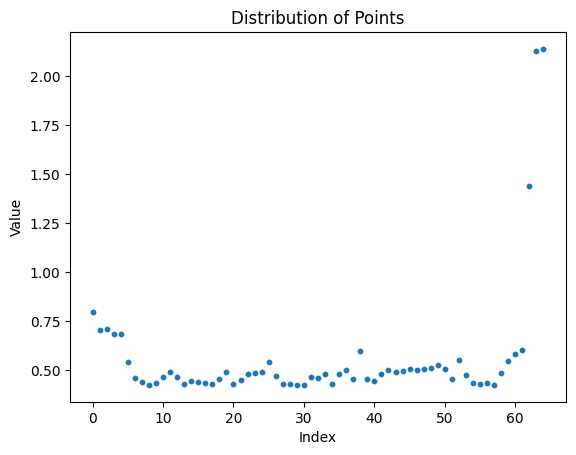

Row: [ 43 183 252]
torch.Size([36])


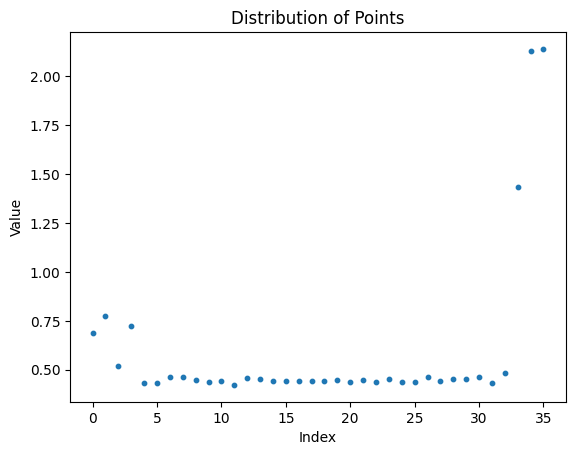

Row: [ 0 10 48]
torch.Size([52])


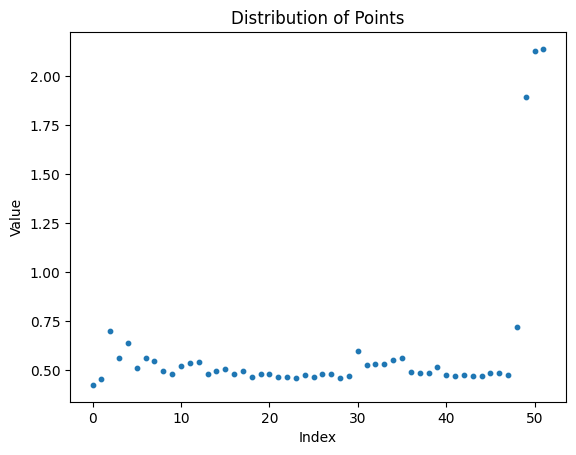

Row: [ 35 112 191]
torch.Size([49])


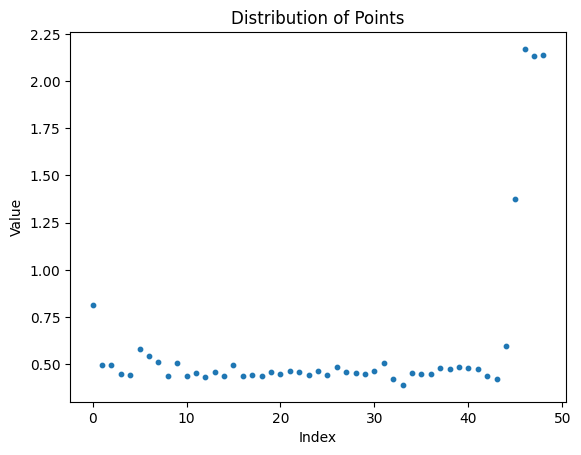

Row: [ 0 16]
torch.Size([61])


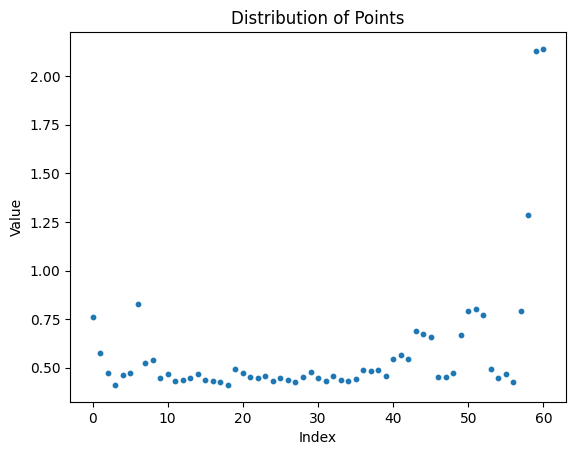

Row: [  6   9  32  85 122]


In [ ]:
for i in range(10):
  track_idx, embeds, target = train_dataset[i]
  print_subplots(embeds)
  print_target(target)